# __Springboard Data Science Capstone 3 Project__
# _Predicting the Price of Energy_

### Pre-Processing & Modeling

##### _Ben Takacs_
###### __Python version 3.10.4__

### __Imports and File Location__

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import load_csv_data, arima_mse, model_eval

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose

### __Load Data__

In [3]:
df = pd.read_csv('./data/df1.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df

,"Average Price of Electricity to Ultimate Customers, Residential",Total Renewable Energy Consumption,Total Petroleum Consumed by the Residential Sector,Natural Gas Consumed by the Electric Power Sector,"Natural Gas Consumed by the Transportation Sector, Vehicle Fuel"
Month,,,,,
1990-02-01,7.48,0.321465,143.972,153.181,0.021
1990-03-01,7.57,0.353956,129.117,214.167,0.023
1990-04-01,7.69,0.334136,108.024,231.641,0.022
1990-05-01,7.96,0.317791,94.930,283.776,0.023
1990-06-01,8.10,0.289276,87.671,345.768,0.022
...,...,...,...,...,...
2024-05-01,16.43,0.758321,53.691,1045.631,4.514
2024-06-01,16.42,0.742351,40.900,1243.853,4.368
2024-07-01,16.63,0.733689,31.619,1534.444,4.514


Average price is in units of cents per kilowatt hour, including taxes.\
Renewable energy consumption is in units of quadrillion Btu (10^15)\
Petroleum consumption is in units of trillion Btu (10^12)\
Natural gas consumed is in units of billion cubic feet (10^12)\
Need to convert  energies to same unit.
Also going to rename columsn to something easier.

In [4]:
df.rename(columns={'Average Price of Electricity to Ultimate Customers, Residential':'Price', 'Total Renewable Energy Consumption':'Renewable', 'Total Petroleum Consumed by the Residential Sector':'Petroleum', 'Natural Gas Consumed by the Electric Power Sector':'Electric', 'Natural Gas Consumed by the Transportation Sector, Vehicle Fuel':'Transportation'}, inplace=True)
df.Renewable *= 1e3
df

,Price,Renewable,Petroleum,Electric,Transportation
Month,,,,,
1990-02-01,7.48,321.465,143.972,153.181,0.021
1990-03-01,7.57,353.956,129.117,214.167,0.023
1990-04-01,7.69,334.136,108.024,231.641,0.022
1990-05-01,7.96,317.791,94.930,283.776,0.023
1990-06-01,8.10,289.276,87.671,345.768,0.022
...,...,...,...,...,...
2024-05-01,16.43,758.321,53.691,1045.631,4.514
2024-06-01,16.42,742.351,40.900,1243.853,4.368
2024-07-01,16.63,733.689,31.619,1534.444,4.514


Renewable and Petroleum now have same units (trillion Btu)

##### Don't need to scale data because it's a time series

### __Test Train Split__

In [77]:
# Make differenced dataframe as well for use with modeling
df_diff = pd.DataFrame()
for col in df.columns:
    df_diff[col] = np.diff(df[col])

df_diff.index = df.index[:-1]
df_diff

,Price,Renewable,Petroleum,Electric,Transportation
Month,,,,,
1990-02-01,0.09,32.491,-14.855,60.986,0.002
1990-03-01,0.12,-19.820,-21.093,17.474,-0.001
1990-04-01,0.27,-16.345,-13.094,52.135,0.001
1990-05-01,0.14,-28.515,-7.259,61.992,-0.001
1990-06-01,0.08,26.596,-2.301,33.816,0.001
...,...,...,...,...,...
2024-04-01,-0.45,21.792,-17.515,163.693,0.146
2024-05-01,-0.01,-15.970,-12.791,198.222,-0.146
2024-06-01,0.21,-8.662,-9.281,290.591,0.146


In [82]:
# 65/35 test train split on data
split = 0.65
split_year = df.index.year[0] + int(split * (df.index.year[-1] - df.index.year[0]))    # find 60% of yearspan
train = df[df.index < str(split_year)]  # split data
test = df[df.index >= str(split_year)]

train_diff = df_diff[df_diff.index < str(split_year)]
test_diff = df_diff[df_diff.index >= str(split_year)]
# print(train_diff, test_diff)

# Split x and y into train and test
xtrain = train.drop(columns=['Price'])
xtest = test.drop(columns=['Price'])
ytrain = train.Price
ytest = test.Price

xtrain_diff = train_diff.drop(columns=['Price'])
xtest_diff = test_diff.drop(columns=['Price'])
ytrain_diff = train_diff.Price
ytest_diff = test_diff.Price
# print(xtrain_diff, xtest_diff, ytrain_diff, ytest_diff)

So train data is from 1990 to 2011, test data is from 2012 to 2024.

### __ARIMA Modeling__

Only takes one variable, price. 

In [83]:
model_price_1 = ARIMA(ytrain_diff, order=(1,1,1))
model_price_1_fit = model_price_1.fit()
print(model_price_1_fit.summary())

model_price_2 = ARIMA(ytrain_diff, order=(1,1,2))
model_price_2_fit = model_price_2.fit()
print(model_price_2_fit.summary())

aic_delta = model_price_2_fit.aic - model_price_1_fit.aic
print(aic_delta)

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  37.478
Date:                Thu, 13 Mar 2025   AIC                            -68.957
Time:                        18:44:48   BIC                            -58.251
Sample:                    02-01-1990   HQIC                           -64.654
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3171      0.243     -1.308      0.191      -0.792       0.158
ma.L1          0.0847      0.259      0.327      0.744      -0.423       0.592
sigma2         0.0440      0.003     13.310      0.0

Model of order (1,1,1) has lower AIC.

In [84]:
# Range of pdq values to test
p = [x for x in range(0, 3)]
d = [x for x in range(0, 3)]
q = [x for x in range(0, 3)]

import warnings
warnings.filterwarnings('ignore')

aic_test = np.inf
for i in p:
    for j in d:
        for k in q:
            try:
                model = ARIMA(ytrain_diff, order=(i, j, k))
                model_fit = model.fit()
                if model_fit.aic < aic_test:
                    aic_test = model_fit.aic
                    best_order_price = (i, j, k)
            except:
                continue

print('\nBest Order:', best_order_price)

# import warnings
# warnings.filterwarnings("ignore")
# best_order_price = model_eval(np.diff(ytrain), p, d, q)


Best Order: (2, 0, 2)


d = 0means data was not differenced (because we already differenced it)

In [112]:
forecast_length = 36 # forecast 3 years

model = ARIMA(ytrain_diff, order=best_order_price)
model_fit = model.fit()
forecast = model_fit.forecast(steps=forecast_length)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  263
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 156.347
Date:                Thu, 13 Mar 2025   AIC                           -300.693
Time:                        19:08:22   BIC                           -279.260
Sample:                    02-01-1990   HQIC                          -292.080
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0157      0.007      2.291      0.022       0.002       0.029
ar.L1          1.7333      0.004    401.215      0.000       1.725       1.742
ar.L2         -0.9971      0.004   -256.671      0.000      -1.005      -0.990
ma.L1         -1.7790      0.025    -71.553      0.000      -1.828      -1.730
ma.L2          0.9901      0.028     35.515      0.000       0.935       1.045
sigma2         0.0172      0.002     11.388      0.000       0.014       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.38   Prob(JB):                         0.84
Heteroskedasticity (H):               2.53   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

12.164901764234601 12.153812874140309


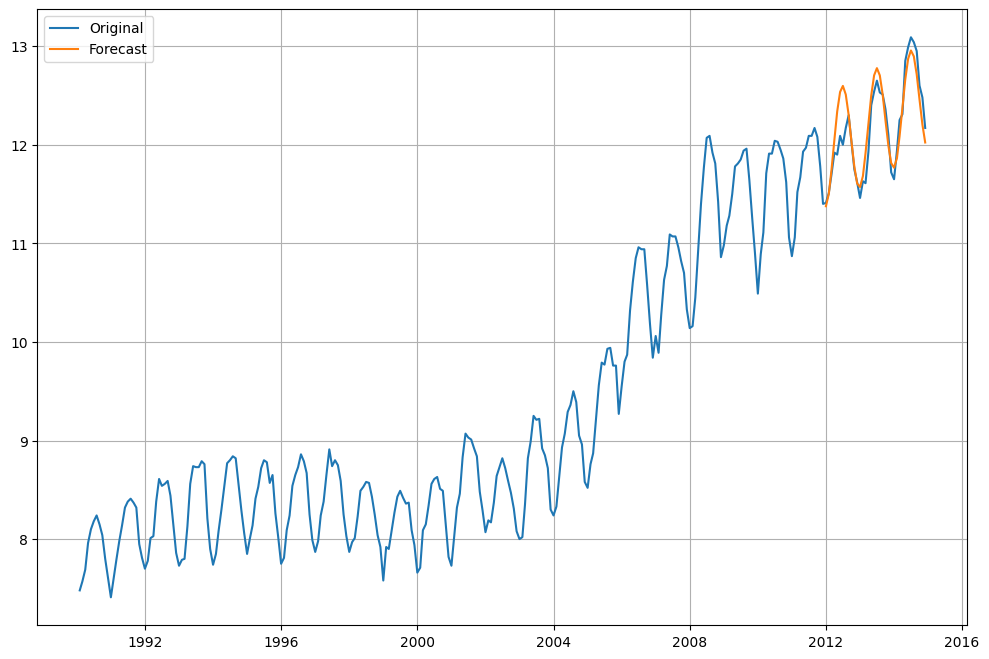

In [113]:
rmse_price = np.sqrt((np.sum((ytest[:forecast_length] - forecast)**2))/len(forecast))
mae = np.sum(np.abs(ytest[:forecast_length]- forecast)) / len(forecast)
print(rmse_price, mae)


plt.figure(figsize=(12, 8))
plt.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
plt.plot(forecast.cumsum()+ytrain[-1], label='Forecast')
plt.grid(True)
plt.legend()
plt.show()

This model does well with prediction, having a RMSE of 12 and a comparable MAE.

### __VAR Model__

In [ ]:
model_var = VAR(train_diff)
model_var_fit = model_var.fit()
print(model_var_fit.summary())
forecast_var = model_var_fit.forecast(train_diff.values[-model_var_fit.k_ar:], steps=30)

forecast_var = pd.DataFrame(forecast_var)
forecast_var.columns = train.columns
forecast_var.index = test.index[:len(forecast_var)]

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Mar, 2025
Time:                     19:04:10
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    10.7645
Nobs:                     262.000    HQIC:                   10.5202
Log likelihood:          -3185.44    FPE:                    31444.5
AIC:                      10.3559    Det(Omega_mle):         28078.7
--------------------------------------------------------------------
Results for equation Price
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.007322         0.009895            0.740           0.459
L1.Price                 -0.026507         0.075215           -0.352           0.725
L1.Renewable             -0.000647         0

This model sees much less correlation between Price and the other features, perhaps due to differencing.

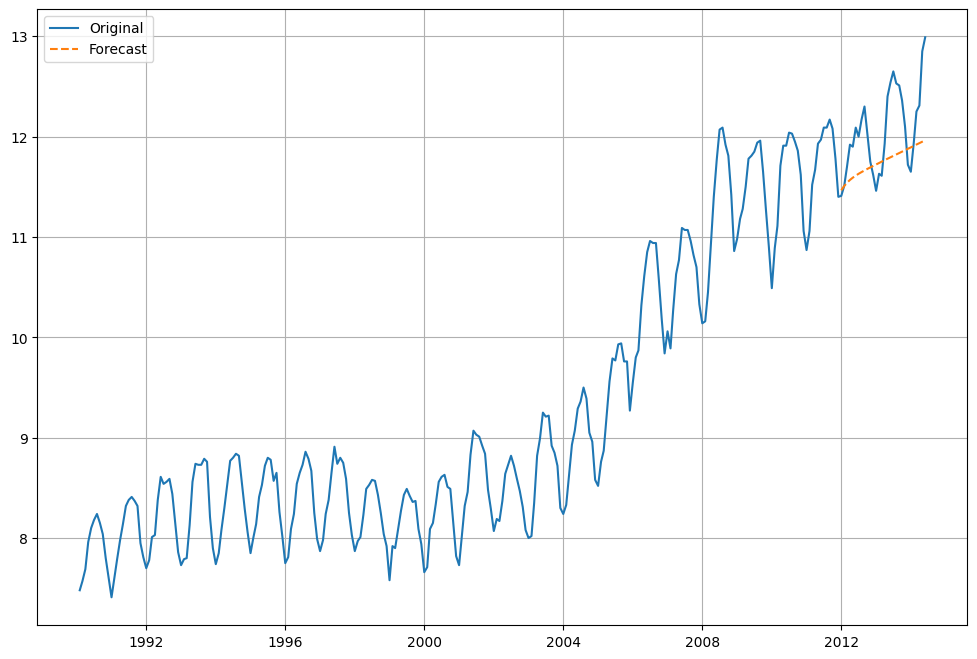

In [108]:
plt.figure(figsize=(12, 8))
plt.plot(pd.concat([ytrain, ytest[:30]]), label='Original')
plt.plot(forecast_var.Price.cumsum()+ytrain[-1], label='Forecast', ls='--')
# plt.plot(ytest[:30], label='True')
# plt.plot(seasonal_decompose(df.Price).trend[:len(train)+len(forecast_var)], label='Trend')
plt.grid(True)
plt.legend()
plt.show()

This model is not forecasting accurately, could be a problem with how the model is set up or the features we chose are not good indicators of price performance.

Future plans: Separate training and testing data using time series split.\
Modeling: ARIMA, SARIMA, FB Prophet, exponential smoothing
 RNN, XGBoost\
Employ 1 step ahead cross validation